In [18]:
import biom
import pandas as pd
import numpy as np
import xarray as xr
import glob
import cmdstanpy
import birdman.visualization as viz
import matplotlib.pyplot as plt
from birdman import NegativeBinomial
from biom.table import Table
from typing import Sequence

In [19]:
def _alr_to_clr(x: np.ndarray) -> np.ndarray:
    """Convert ALR coordinates to centered CLR coordinates.

    :param x: Matrix of ALR coordinates (features x draws)
    :type x: np.ndarray

    :returns: Matrix of centered CLR coordinates
    :rtype: np.ndarray
    """
    num_draws = x.shape[1]
    z = np.zeros((1, num_draws))
    x_clr = np.vstack((z, x))
    x_clr = x_clr - x_clr.mean(axis=0).reshape(1, -1)
    return x_clr


def _beta_alr_to_clr(beta: np.ndarray) -> np.ndarray:
    """Convert feature-covariate coefficients from ALR to CLR.

    :param beta: Matrix of beta ALR coordinates (n draws x p covariates x
        d features)
    :type beta: np.ndarray

    :returns: Matrix of beta CLR coordinates (n draws x p covariates x d+1
        features)
    :rtype: np.ndarray
    """
    num_draws, num_covariates, num_features = beta.shape
    beta_clr = np.zeros((num_draws, num_covariates, num_features+1))
    for i in range(num_covariates):  # TODO: vectorize
        beta_slice = beta[:, i, :].T  # features x draws
        beta_clr[:, i, :] = _alr_to_clr(beta_slice).T
    return beta_clr


def posterior_alr_to_clr(
    posterior: xr.Dataset,
    alr_params: list,
    dim_replacement: dict,
    new_labels: Sequence
) -> xr.Dataset:
    """Convert posterior draws from ALR to CLR.

    :param posterior: Posterior draws for fitted parameters
    :type posterior: xr.Dataset

    :param alr_params: List of parameters to convert from ALR to CLR
    :type alr_params: list

    :param dim_replacement: Dictionary of updated posterior dimension names
        e.g. {"feature_alr": "feature"}
    :type dim_replacement: dict

    :param new_labels: Coordinates to assign to CLR posterior draws
    :type new_labels: Sequence
    """
    new_posterior = posterior.copy()
    for param in alr_params:
        param_da = posterior[param]
        all_chain_alr_coords = param_da
        all_chain_clr_coords = []

        for i, chain_alr_coords in all_chain_alr_coords.groupby("chain"):
            chain_clr_coords = _beta_alr_to_clr(chain_alr_coords[0])
            all_chain_clr_coords.append(chain_clr_coords)

        all_chain_clr_coords = np.array(all_chain_clr_coords)

        new_dims = [
            dim_replacement[x]
            if x in dim_replacement else x
            for x in param_da.dims
        ]
        # Replace coords with updated labels

        new_coords = dict()
        for dim in param_da.dims:
            if dim in dim_replacement:
                new_name = dim_replacement[dim]
                new_coords[new_name] = new_labels
            else:
                new_coords[dim] = param_da.coords.get(dim).data

        new_param_da = xr.DataArray(
            all_chain_clr_coords,
            dims=new_dims,
            coords=new_coords
        )
        new_posterior[param] = new_param_da

    new_posterior = new_posterior.drop_vars(dim_replacement.keys())
    return new_posterior

In [20]:
# T2D
t2d = pd.read_csv('../data/t2d/clean.csv', index_col=0)
t2d

,IRIS,Gender,Ethnicity,genus_Akkermansia,genus_Alistipes,genus_Anaerotruncus,genus_Anaerovorax,genus_Bacteroides,genus_Barnesiella,genus_Bilophila,...,genus_Veillonella,genus_unclassified_Bacteria,genus_unclassified_Clostridiales,genus_unclassified_Clostridiales_Incertae.Sedis.XIII,genus_unclassified_Coriobacteriaceae,genus_unclassified_Erysipelotrichaceae,genus_unclassified_Firmicutes,genus_unclassified_Lachnospiraceae,genus_unclassified_Porphyromonadaceae,genus_unclassified_Ruminococcaceae
0,0,0,0,0.452125,1.094397,0.029578,0.021127,16.170878,0.346489,0.004230,...,0.008450,12.465140,1.825403,0.029578,0.042255,0.219724,0.840869,6.714274,0.000000,5.729739
1,0,0,0,0.009170,7.764379,0.091705,0.041267,32.055573,1.614013,0.082535,...,0.001530,13.019090,2.298745,0.055023,0.184939,1.740871,1.056139,7.417427,0.004590,4.889419
2,0,0,0,0.000000,4.677102,0.014871,0.018589,26.549429,0.777038,0.003720,...,0.014871,3.680708,2.409191,0.044615,0.115254,0.453582,17.113433,2.795851,0.000000,10.242778
3,0,0,0,0.236451,0.788170,0.000000,0.030025,58.118150,0.127608,0.003750,...,0.000000,4.665215,4.042186,0.026272,0.018766,0.304008,0.848221,12.160336,0.123855,2.814893
4,0,0,0,0.298811,1.051814,0.035857,0.029881,40.022710,0.298811,0.005980,...,0.000000,4.261041,1.243053,0.011952,0.023905,0.149405,2.486105,16.745354,0.233072,2.778940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,1,1,0,0.012752,1.349214,0.028055,0.017854,53.557947,0.000000,1.351765,...,0.010202,0.066313,0.390226,0.040808,0.895225,0.869720,0.002550,3.065701,0.369822,1.379820
327,1,1,0,4.438057,0.881766,0.038973,0.311785,25.844010,0.004870,0.107176,...,0.000000,0.107176,0.316656,0.657670,0.993813,6.411068,0.024358,4.667024,0.248453,7.711794
328,1,1,0,0.095145,2.828414,0.021624,0.038923,49.981620,0.004320,0.019462,...,0.004320,0.030273,1.076873,0.069197,0.118932,1.909396,0.103795,4.393988,0.270300,2.538653
329,1,1,0,1.329974,2.369932,0.049801,0.161120,74.276424,0.000000,0.002930,...,0.000000,0.131826,3.890321,0.328099,0.020506,1.801617,0.002930,0.978439,0.172838,2.164870


In [21]:
metadata = t2d[['IRIS', 'Gender', 'Ethnicity']]
metadata

,IRIS,Gender,Ethnicity
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
326,1,1,0
327,1,1,0
328,1,1,0
329,1,1,0


In [22]:
otu_table = t2d.iloc[:, 3:].T
otu_table = Table(otu_table.to_numpy(), observation_ids=list(otu_table.index), sample_ids=list(otu_table.columns))
otu_table

45 x 331 <class 'biom.table.Table'> with 12457 nonzero entries (83% dense)

In [23]:
otu_table = pd.read_csv('../data/t2d/otu_table.csv', index_col=0).T
otu_table = Table(otu_table.to_numpy(), observation_ids=list(otu_table.index), sample_ids=list(otu_table.columns))

metadata = pd.read_csv('../data/t2d/metadata.csv', index_col=0)

filter_meta = metadata.loc[metadata.index.intersection(otu_table.to_dataframe().columns)]
filter_otu = otu_table.filter(filter_meta.index.tolist(), inplace=False)

prevalence = filter_otu.to_dataframe().clip(upper=1).sum(axis=1)
features_to_keep = prevalence[prevalence >= 5].index.tolist()
filter_otu = filter_otu.filter(features_to_keep, axis='observation', inplace=False)

nb = NegativeBinomial(
    table = filter_otu,
    formula = ' + '.join(list(metadata.columns)),
    metadata = filter_meta
)

In [24]:
nb.compile_model()
nb.fit_model(method='vi', num_draws=100)

14:35:05 - cmdstanpy - INFO - compiling stan file /opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial.stan to exe file /opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial


ValueError: Failed to compile Stan model '/opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial.stan'. Console:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=negative_binomial.stan --o=/opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial.hpp /opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial.stan
Internal compiler error:
(Sys_error
 "/opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial.hpp: Permission denied")
Raised by primitive operation at Stdlib.open_out_gen in file "stdlib.ml", line 331, characters 29-55
Called from Stdio__Out_channel.with_file in file "src/out_channel.ml", line 81, characters 15-66
Called from Dune__exe__Stanc.use_file in file "src/stanc/stanc.ml", line 370, characters 4-52
Called from Common__ICE.with_exn_message in file "src/common/ICE.ml", line 14, characters 9-15


This should never happen. Please file a bug at https://github.com/stan-dev/stanc3/issues/new
and include this message and the model that caused this issue.
make: *** [make/program:66: /opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial.hpp] Error 2

Command ['make', 'STANCFLAGS+=--filename-in-msg=negative_binomial.stan', '/opt/conda/lib/python3.11/site-packages/birdman/templates/negative_binomial']
	error during processing No such file or directory


In [6]:
# PCOS
pcos = pd.read_csv('../data/pcos/clean.csv', index_col=0)
pcos

,group,region,01D2Z36,0319-6G20,0319-7L14,27F-1492R,37-13,67-14,A2,Abiotrophia,...,Xanthomonas,Xenorhabdus,Xylanibacillus,Yersinia,Youngiibacter,Zavarzinia,Zoogloea,ZOR0006,Unclassified,study_site
SRR4457864,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.640935,1
SRR4457873,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.630561,1
SRR4457876,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.448002,1
SRR4457877,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.459400,1
SRR4457878,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.031991,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR24874401,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.423813,14
SRR24874402,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.704500,14
SRR24874404,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.894488,14
SRR24874405,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111772,14


In [7]:
metadata = pcos[['group', 'region', 'study_site']]
metadata

,group,region,study_site
SRR4457864,0,0,1
SRR4457873,0,0,1
SRR4457876,0,0,1
SRR4457877,0,0,1
SRR4457878,0,0,1
...,...,...,...
SRR24874401,1,1,14
SRR24874402,1,1,14
SRR24874404,1,1,14
SRR24874405,1,1,14


In [8]:
otu_table = pcos.iloc[:, 2:-1].T
otu_table = Table(otu_table.to_numpy(), observation_ids=list(otu_table.index), sample_ids=list(otu_table.columns))
otu_table

1127 x 948 <class 'biom.table.Table'> with 98801 nonzero entries (9% dense)

In [12]:
prevalence = otu_table.to_dataframe().clip(upper=1).sum(axis=1)
features_to_keep = prevalence[prevalence >= 5].index.tolist()
otu_table_filt = otu_table.filter(features_to_keep, axis='observation', inplace=False)
otu_table_filt

44 x 331 <class 'biom.table.Table'> with 12249 nonzero entries (84% dense)

In [13]:
nb = NegativeBinomial(
    table = otu_table_filt,
    formula = 'IRIS + Gender + Ethnicity',
    # formula = 'group',
    metadata = metadata)

nb.compile_model()
nb.fit_model(method='vi', num_draws=100)

KeyError: "None of [Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n       ...\n       321, 322, 323, 324, 325, 326, 327, 328, 329, 330],\n      dtype='int64', length=331)] are in the [index]"

In [66]:
inference = nb.to_inference()
inference.posterior = posterior_alr_to_clr(
    posterior = inference.posterior,
    alr_params = ['beta_var'],
    dim_replacement = {'feature_alr': 'feature'},
    new_labels = nb.feature_names
)

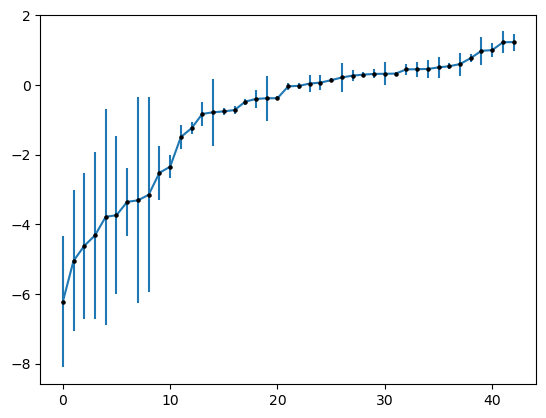

In [136]:
covariate = inference.posterior['covariate'].to_numpy()[1]

ax = viz.plot_parameter_estimates(
    inference,
    parameter = 'beta_var',
    coords = {'covariate': covariate}
)

In [129]:
inference.posterior['beta_var'].sel({'covariate': 'IRIS'})

<xarray.DataArray 'beta_var' (chain: 1, draw: 100, feature: 44)> Size: 35kB
array([[[ 0.69682339,  0.77485639, -7.89991661, ...,  0.35444039,
          0.85772239,  0.35619039],
        [ 0.98894049,  0.86281549,  0.21110149, ...,  0.68976949,
          0.14221649,  0.54717449],
        [ 1.18794274,  1.09584114, -4.93546726, ...,  0.80581374,
          0.12297274,  0.83649274],
        ...,
        [ 0.97171829,  0.99312259,  2.71145829, ...,  0.64049329,
          0.30724629,  0.41514229],
        [ 0.98070239,  0.87739739, -1.57054761, ...,  0.60088339,
          0.47716439,  0.52265239],
        [ 0.94941158,  0.91755338, -1.35351842, ...,  0.47103158,
          0.01485658,  0.48915158]]], shape=(1, 100, 44))
Coordinates:
    covariate  <U4 16B 'IRIS'
  * draw       (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * chain      (chain) int64 8B 0
  * feature    (feature) <U52 9kB 'genus_Akkermansia' ... 'genus_unclassified...

In [107]:
t2d_clr.prod(axis=1)

0      3.434075e+11
1      1.038100e+12
2      2.067531e+11
3      1.809140e+09
4      8.066371e+10
           ...     
326    1.002356e+10
327    6.390350e+12
328    5.546672e+10
329    2.065934e+08
330    1.982066e+11
Length: 331, dtype: float64

In [117]:
t2d_clr = t2d.iloc[:, 3:] + 1
t2d_clr_geom_mean = t2d_clr.prod(axis=1)
for sample in t2d_clr.index:
    t2d_clr.loc[sample] = np.log(t2d_clr.loc[sample] / t2d_clr_geom_mean[sample])
t2d_clr

,genus_Akkermansia,genus_Alistipes,genus_Anaerotruncus,genus_Anaerovorax,genus_Bacteroides,genus_Barnesiella,genus_Bilophila,genus_Blautia,genus_Butyricicoccus,genus_Butyricimonas,...,genus_Veillonella,genus_unclassified_Bacteria,genus_unclassified_Clostridiales,genus_unclassified_Clostridiales_Incertae.Sedis.XIII,genus_unclassified_Coriobacteriaceae,genus_unclassified_Erysipelotrichaceae,genus_unclassified_Firmicutes,genus_unclassified_Lachnospiraceae,genus_unclassified_Porphyromonadaceae,genus_unclassified_Ruminococcaceae
0,-26.189155,-25.822918,-26.533034,-26.541276,-23.718969,-26.264684,-26.557963,-25.760356,-26.500729,-26.293333,...,-26.553769,-23.962080,-25.523533,-26.533034,-26.520797,-26.363559,-25.951946,-24.519111,-26.562184,-24.655647
1,-27.659285,-25.497718,-27.580672,-27.627975,-24.170223,-26.707527,-27.589108,-26.313484,-27.362658,-27.465735,...,-27.666884,-25.027993,-26.474871,-27.614851,-27.498722,-26.660137,-26.947583,-25.538109,-27.663834,-25.895256
2,-26.054791,-24.318350,-26.040029,-26.036373,-22.738809,-25.479843,-26.051078,-24.878636,-25.979614,-25.949048,...,-26.040029,-24.511342,-24.828316,-26.011143,-25.945709,-25.680760,-23.158137,-24.720883,-26.054791,-23.635065
3,-21.103872,-20.734925,-21.316118,-21.286534,-17.236580,-21.196019,-21.312375,-20.501940,-21.268479,-21.243738,...,-21.316118,-19.581773,-19.698278,-21.290185,-21.297526,-21.050675,-20.701894,-18.738910,-21.199353,-19.977205
4,-24.852106,-24.394830,-25.078325,-25.084111,-21.399429,-24.852106,-25.107592,-24.538680,-25.000651,-24.880102,...,-25.113555,-23.453226,-24.305717,-25.101673,-25.089931,-24.974310,-23.864769,-22.237431,-24.904046,-23.784111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,-23.015532,-22.174123,-23.000535,-23.010508,-19.028940,-23.028204,-22.173038,-21.939983,-22.870445,-23.025657,...,-23.018054,-22.963997,-22.698737,-22.988207,-22.388866,-22.402415,-23.025657,-21.625618,-22.713523,-22.161179
327,-27.792388,-28.853600,-29.447577,-29.214422,-26.195767,-29.480952,-29.383998,-26.646688,-29.214422,-29.485810,...,-29.485810,-29.383998,-29.210715,-28.980397,-28.795761,-27.482836,-29.461744,-27.751146,-29.263905,-27.321132
328,-24.648162,-23.396598,-24.717656,-24.700864,-20.807584,-24.734738,-24.719774,-23.195204,-24.662080,-24.736891,...,-24.734738,-24.709225,-24.008186,-24.672141,-24.626675,-23.671104,-24.640295,-23.053764,-24.499796,-23.475303
329,-18.300406,-17.931370,-19.097663,-18.996878,-14.825096,-19.146263,-19.143337,-18.409215,-19.103259,-19.146263,...,-19.146263,-19.022431,-17.559005,-18.862514,-19.125964,-18.116066,-19.143337,-18.463955,-18.986837,-17.994151


In [124]:
iris0 = t2d[t2d['IRIS'] == 0].index
iris1 = t2d[t2d['IRIS'] == 1].index
for genus in t2d_clr.columns:
    t2d_clr0 = t2d_clr.loc[iris0, genus].mean()
    t2d_clr1 = t2d_clr.loc[iris1, genus].mean()
    print(genus, ': ', t2d_clr0 / t2d_clr1)

genus_Akkermansia :  1.0614383019740816
genus_Alistipes :  1.0628395495846399
genus_Anaerotruncus :  1.0637342307039177
genus_Anaerovorax :  1.063312665008276
genus_Bacteroides :  1.0831481964039522
genus_Barnesiella :  1.059785608283446
genus_Bilophila :  1.0636146497234262
genus_Blautia :  1.0798613691376029
genus_Butyricicoccus :  1.0621064344074644
genus_Butyricimonas :  1.0609944504942554
genus_Clostridium.IV :  1.0648294744512328
genus_Clostridium.XI :  1.0578506927951299
genus_Clostridium.XVIII :  1.0629136194076079
genus_Clostridium.XlVa :  1.069325831059762
genus_Clostridium.XlVb :  1.0686762575451305
genus_Clostridium.sensu.stricto :  1.060224767980633
genus_Collinsella :  1.0683964357752846
genus_Coprococcus :  1.0607267851341333
genus_Dorea :  1.0658012729980855
genus_Eggerthella :  1.0638029416179438
genus_Erysipelotrichaceae_incertae_sedis :  1.0650948125605428
genus_Faecalibacterium :  1.0763936820557356
genus_Flavonifractor :  1.0659832663031112
genus_Holdemania :  1.06

In [88]:
param_means = inference.posterior['beta_var'].sel(
    **{'covariate': covariate}
    ).mean(['chain', 'draw'])
param_stds = inference.posterior['beta_var'].sel(
    **{'covariate': covariate}
    ).std(['chain', 'draw'])
sort_indices = param_means.argsort().data
param_means = param_means.data[sort_indices]
param_stds = param_stds.data[sort_indices]
param_labels = inference.posterior['feature'].data[sort_indices]

differential_results = pd.DataFrame({'feature': param_labels, 'mean clr': param_means, 'std clr': param_stds})
differential_results

,feature,mean clr,std clr
0,genus_Butyricimonas,-5.323967,1.834405
1,genus_Butyricicoccus,-4.146532,1.987774
2,genus_Eggerthella,-3.715014,2.040729
3,genus_unclassified_Coriobacteriaceae,-3.414604,2.368927
4,genus_unclassified_Clostridiales_Incertae.Sedi...,-2.879576,3.016752
5,genus_Pseudoflavonifractor,-2.835821,2.203686
6,genus_Odoribacter,-2.450561,0.986599
7,genus_Anaerovorax,-2.408057,2.883061
8,genus_Anaerotruncus,-2.248695,2.758070
9,genus_Clostridium.sensu.stricto,-1.617568,0.797942


In [87]:
t2d_differential_results[t2d_differential_results['feature'].isin([
    'genus_Butyricimonas', 'genus_Clostridium.XlVb', 'genus_Odoribacter', 
    'genus_unclassified_Bacteria', 'genus_unclassified_Firmicutes'])]

,feature,mean clr,std clr
0,genus_Butyricimonas,-5.248127,1.920443
7,genus_Odoribacter,-2.297405,1.073747
10,genus_unclassified_Firmicutes,-1.257910,0.348004
13,genus_unclassified_Bacteria,-0.062040,0.170906
39,genus_Clostridium.XlVb,1.952735,0.327837


In [83]:
pcos_differential_results[pcos_differential_results['feature'].isin([
    'Alistipes', 'Blautia', 'Burkholderia', 'Desulfovibrio', 'Holdemanella', 'Knoellia',
    'Prevotellaceae_NK3B31_group', 'Ruminococcus', 'Ruminococcus_gnavus_group'])]

,feature,mean clr,std clr
0,Burkholderia,-8.716349,1.432262
66,Prevotellaceae_NK3B31_group,-1.537585,0.491478
84,Holdemanella,-0.319587,0.222763
95,Desulfovibrio,-0.060514,0.481392
103,Ruminococcus,0.043816,0.122938
180,Blautia,1.022139,0.100622
194,Alistipes,1.159245,0.109263
232,Ruminococcus_gnavus_group,2.046355,0.190157
263,Knoellia,5.056818,0.278296


In [84]:
pcos_differential_results

,feature,mean clr,std clr
0,Burkholderia,-8.716349,1.432262
1,Duncaniella,-6.408369,1.880423
2,Herbinix,-6.094212,1.825072
3,Acetatifactor,-5.863909,2.217588
4,Lachnospiraceae_UCG-008,-5.088377,1.787757
...,...,...,...
263,Knoellia,5.056818,0.278296
264,Mesorhizobium,5.817555,0.383706
265,Microbacterium,5.823790,0.334188
266,Duganella,7.194721,0.398481
